##Brain Tumor Detection using Pre-Trained models

##ResNet50

Using this model the pretrained ImageNet weights has been used to perform this task. Also the detection of Brain tumors has been done by using Computer Vision.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
import os
os.chdir("/content/drive/MyDrive/ColabNotebooks/ANN/Project/Dataset")

Mounted at /content/drive/


In [ ]:
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("Import successful")

Import successful


#Creating the Directory Structure

In [ ]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── Brain_Tumor_Detection
│   ├── no
│   ├── pred
│   └── yes
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

13 directories


In [ ]:
##/content/drive/MyDrive/ColabNotebooks/ANN/Project/Dataset/Brain_Tumor_Detection/TRAIN/YES
IMG_PATH = "/content/drive/MyDrive/ColabNotebooks/ANN/Project/Dataset/Brain_Tumor_Detection"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [ ]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:08<00:00,  4.23s/it]
<ipython-input-31-e1b30ccf3e1c>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



1800 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


600 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

600 images loaded from VAL/ directory.


Training set :
0    900
1    900
dtype: int64
-------------
Testing set :
0    300
1    300
dtype: int64
-------------
Validation set :
0    300
1    300
dtype: int64


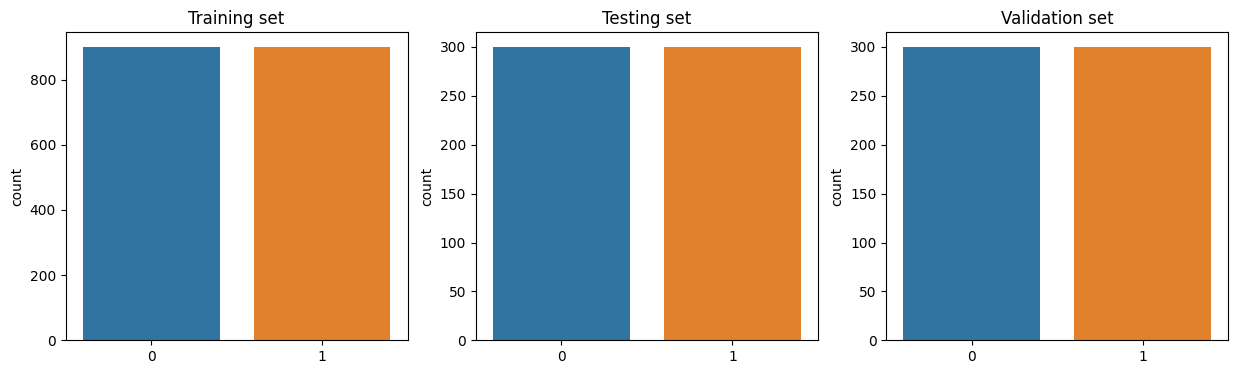

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1,3,figsize=(15,4))
sns.countplot(x=y_train,ax=ax[0]).set_title("Training set")
print("Training set :")
print(pd.value_counts(y_train))

sns.countplot(x=y_test,ax=ax[1]).set_title("Testing set")
print("-------------")
print("Testing set :")
print(pd.value_counts(y_test))

sns.countplot(x=y_val,ax=ax[2]).set_title("Validation set")
print("-------------")
print("Validation set :")
print(pd.value_counts(y_val))


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
  for index in range(len(labels_dict)):
    imgs = X[np.argwhere(y == index)][:n]
    j = 10
    i = int(n/j)

    plt.figure(figsize=(15,6))
    c = 1
  for img in imgs:
      plt.subplot(i,j,c)
      plt.imshow(img[0])
      plt.xticks([])
      plt.yticks([])
      c += 1
  plt.suptitle('Tumor: {}'.format(labels_dict[index]))
  plt.show()

<Figure size 1500x600 with 0 Axes>

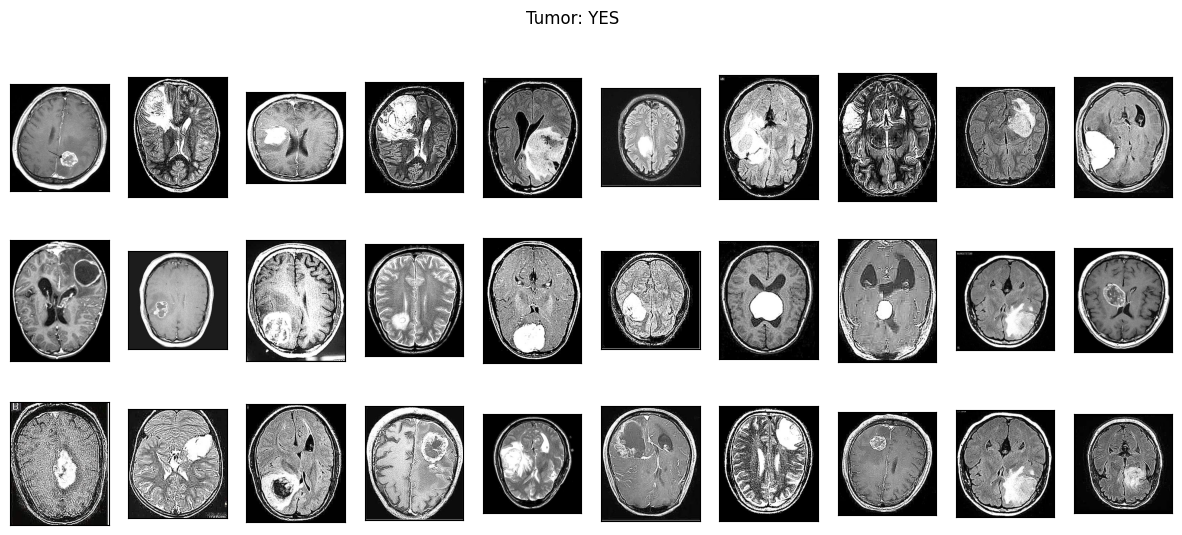

In [ ]:
plot_samples(X_train, y_train, labels, 30)

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
import imutils
img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/ANN/Project/Dataset/VAL/NO/no117.jpg')
#img = cv2.imread('./VAL/NO/no800.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

Let's visualize how the cropping works

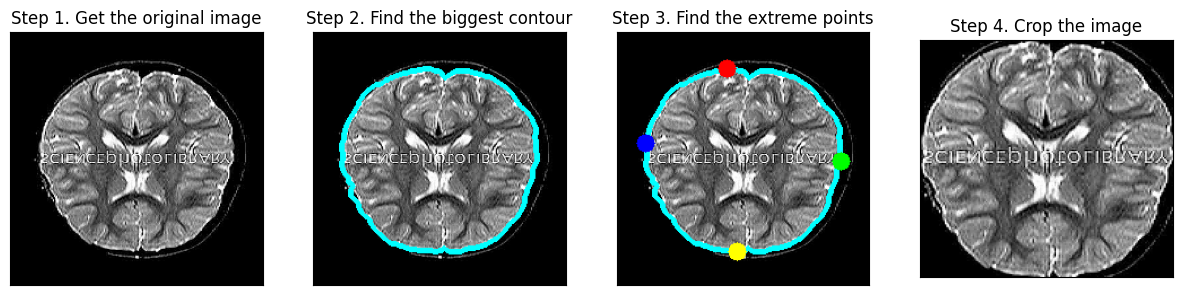

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

<ipython-input-37-65876982ba26>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Let's visualize the images after being cropped

<Figure size 1500x600 with 0 Axes>

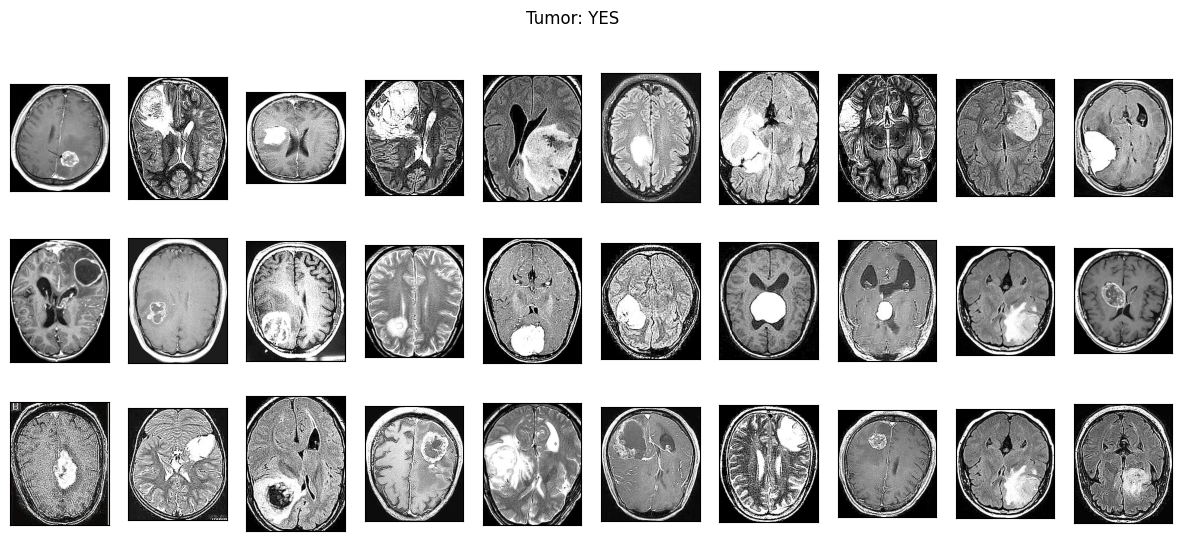

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

Resizing the images

Now that we have cropped the images, we can resize them without suffering from heavy distortions or resizing artefacts

In [ ]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

<Figure size 1500x600 with 0 Axes>

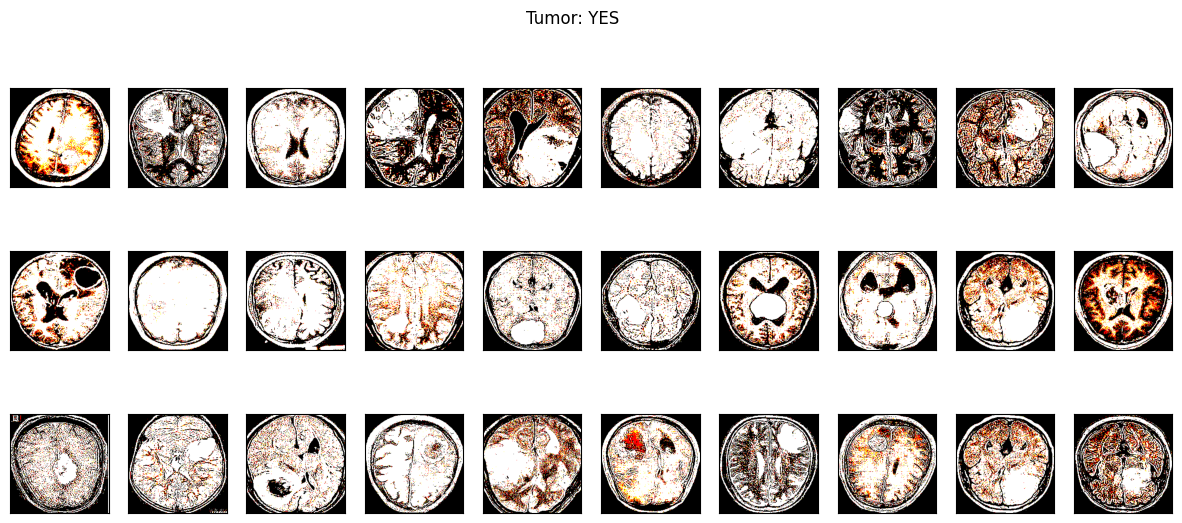

In [ ]:
plot_samples(X_train_prep, y_train, labels, 30)

Image Augmentation

We will perform data augmentation to increase the number of training samples we have

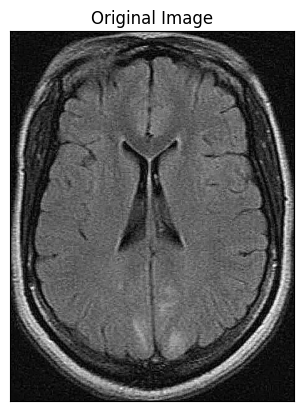

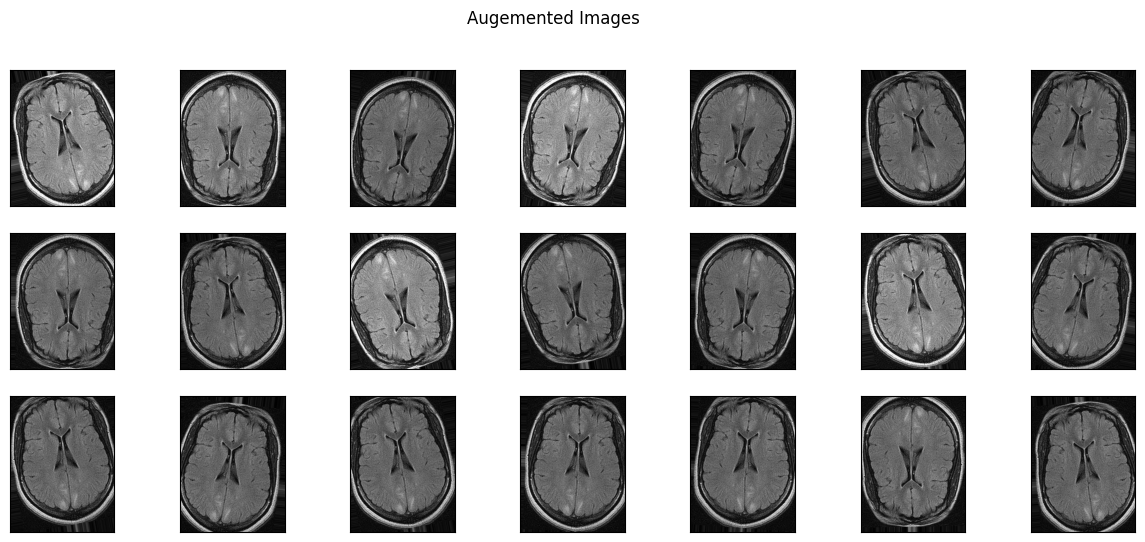

In [ ]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
!rm -rf preview/

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


Creating the model

Here we will be using a pretrained ResNet50 model with ImageNet weights from keras. We will use transfer learning for this task. We will be using binary cross entropy as the loss function and accuracy and AUC as our monitoring metrics.

In [ ]:
base_Neural_Net= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                         

TRAINING !!!

In [ ]:
EPOCHS = 2  #30
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

<ipython-input-51-446e65f61fe9>:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/2
50/50 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8484 - auc: 0.9200

50/50 [==============================] - 53s 736ms/step - loss: 0.3939 - accuracy: 0.8484 - auc: 0.9200 - val_loss: 0.3228 - val_accuracy: 0.9175 - val_auc: 0.9662
Epoch 2/2
50/50 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9296 - auc: 0.9796

50/50 [==============================] - 34s 681ms/step - loss: 0.1827 - accuracy: 0.9296 - auc: 0.9796 - val_loss: 0.1718 - val_accuracy: 0.9425 - val_auc: 0.9896


Let's have a look at the performance of our model

Validating with the training set

In [ ]:
import seaborn as sns
# Libraries and modules for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

def confusion_matrix_plot(model, X, y, data):
  pred = model.predict(X)

  pred = [1 if x>0.5 else 0 for x in pred]

  print('\n' + 'Shape of y:', y.shape)
  print('Shape of predictions:', len(pred))

  print()
  print('------------------------'+data+'set Metrics'+'------------------------')
  print()

  accuracy = accuracy_score(y, pred)
  print('\n'+data+ ' Accuracy Score = %.2f' % accuracy)


  if data == 'Test Data':
    print('Precision score is :', np.round(metrics.precision_score(y, pred, average='weighted'),4))
    print('Recall score is :', np.round(metrics.recall_score(y, pred, average='weighted'),4))
    print('F1 Score is :', np.round(metrics.f1_score(y, pred, average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y, pred),4))
    print('\n'+'\t\tClassification Report:\n', metrics.classification_report(y_test, pred))

  # Define labels for x and y axes
  labels = ['no', 'yes']

  # Create heatmap
  sns.heatmap(confusion_matrix(y, pred), annot = True, fmt='g',  xticklabels=labels, yticklabels=labels )
  # Add title
  plt.title('\n\n'+'Confusion Matrix for '+ data)
  plt.xlabel('Predicted Value')
  plt.ylabel('True Value')
  # Show plot
  plt.show()

57/57 [==============================] - 6s 94ms/step

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 0.97


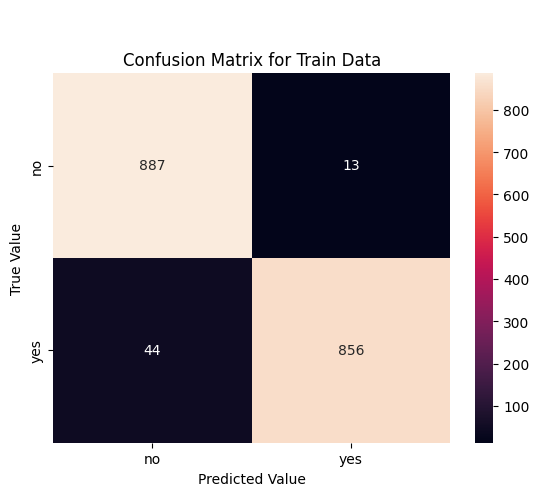

19/19 [==============================] - 3s 143ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.94


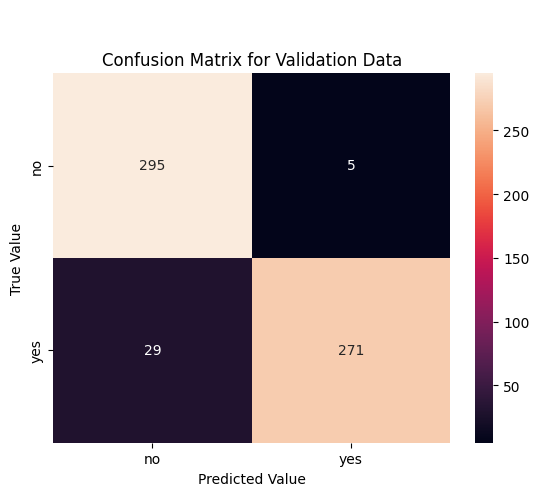

19/19 [==============================] - 2s 91ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.87
Precision score is : 0.8703
Recall score is : 0.87
F1 Score is : 0.87
Cohen Kappa Score: 0.74

		Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       300
           1       0.86      0.88      0.87       300

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



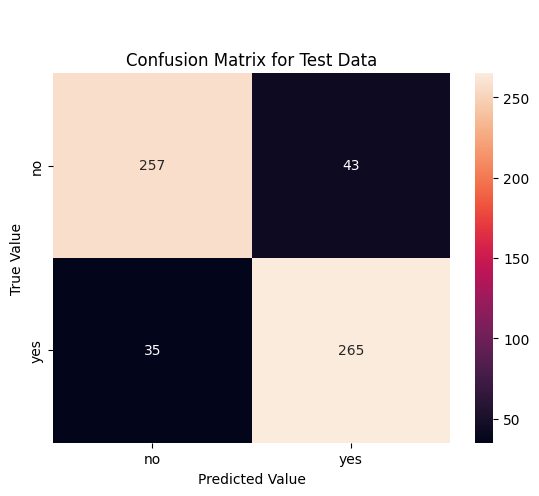

In [ ]:
confusion_matrix_plot(model, X_train_prep, y_train, "Train Data")
confusion_matrix_plot(model, X_val_prep, y_val, "Validation Data")
confusion_matrix_plot(model, X_test_prep, y_test, "Test Data")

Conclusion

A seen from the metrics, the model performs pretty well. We are able to correctly classify all the images in the test set with very few false positives and false negatives in the validation set. This performance can be firther enhanced by hyper parameter tuning.

# Now we will be creating our ML Classifiers

From here on, we will be using various neural networks woith pretrained Image Net weights and extracting a latent representation of our data. This representation will then be used by classical ML models such as K Nearest Neighbours, Support Vector MAchines, etc. to perform the classification task. Various metrics will then be used to evaluate the performance of the models.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def models_compare(X_train1, y_train1, X_val1, y_val1, X_test1, y_test1):
  classifer_name = [ "K Nearest Neighbour Classifier", "Random Forest Classifier", "XGB Classifier" ]
  ml_models = [ KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier()]

  for name,ml_model in zip(classifer_name,ml_models):
    print("--------------------------------{}---------------------------------- ".format(name))
    model1 = ml_model.fit(X_train1,y_train1)
    confusion_matrix_plot(model1, X_train1, y_train1, "Train Data")
    confusion_matrix_plot(model1, X_val1, y_val1, "Validation Data")
    confusion_matrix_plot(model1, X_test1, y_test1, "Test Data")

19/19 [==============================] - 2s 85ms/step
--------------------------------K Nearest Neighbour Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 0.93


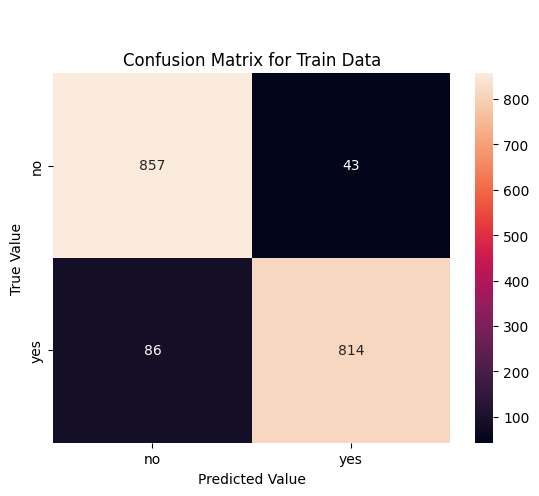


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.86


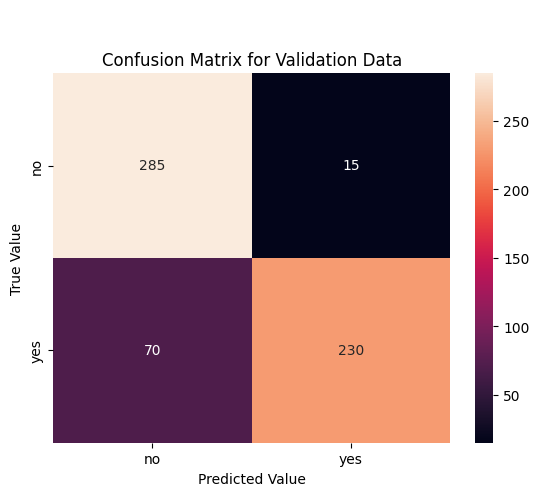


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.82
Precision score is : 0.8235
Recall score is : 0.8233
F1 Score is : 0.8233
Cohen Kappa Score: 0.6467

		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       300
           1       0.82      0.83      0.83       300

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



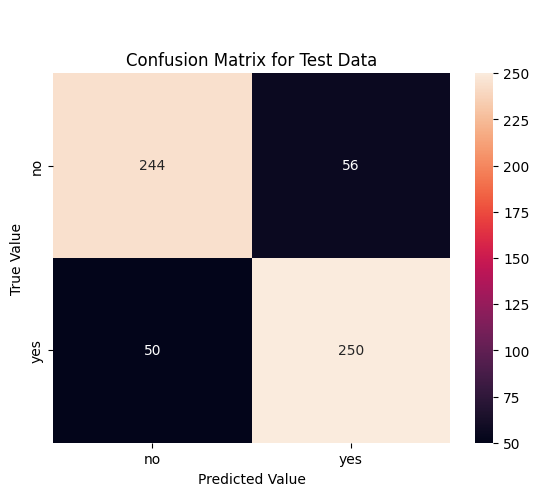

--------------------------------Random Forest Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 1.00


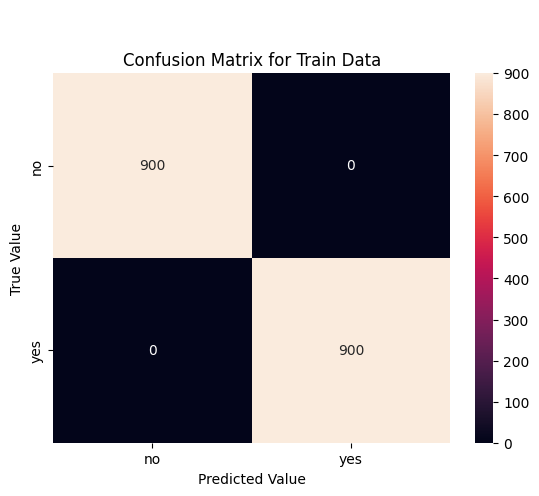


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.86


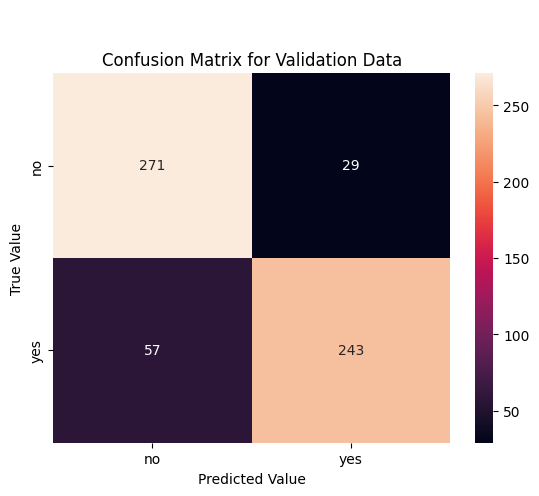


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.80
Precision score is : 0.8005
Recall score is : 0.7967
F1 Score is : 0.796
Cohen Kappa Score: 0.5933

		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78       300
           1       0.77      0.85      0.81       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



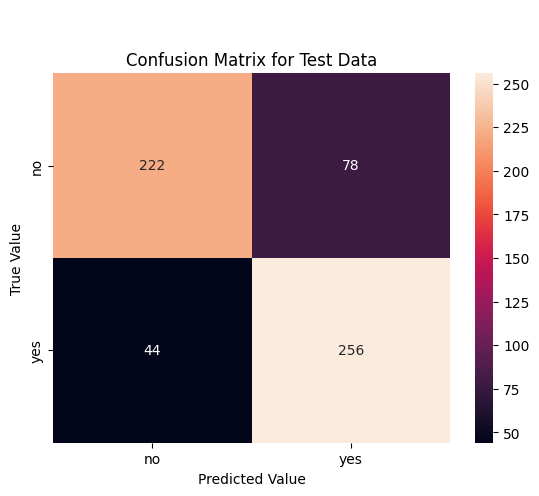

--------------------------------XGB Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 1.00


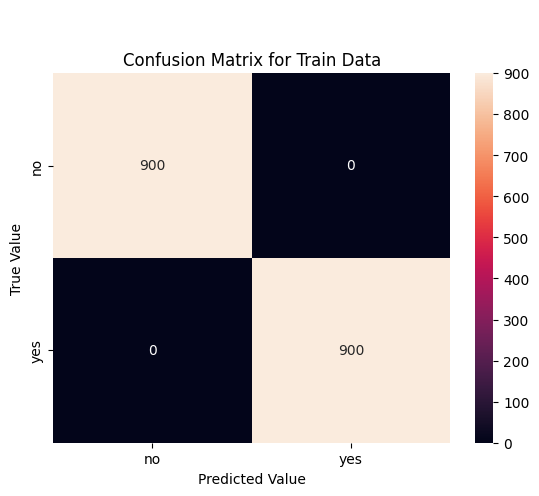


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.87


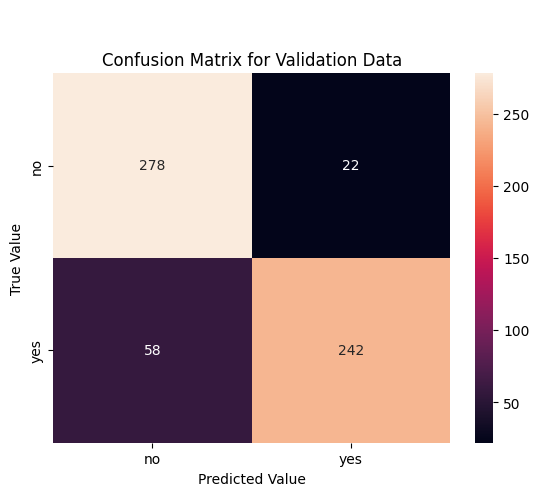


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.83
Precision score is : 0.8309
Recall score is : 0.83
F1 Score is : 0.8299
Cohen Kappa Score: 0.66

		Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83       300
           1       0.81      0.86      0.83       300

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



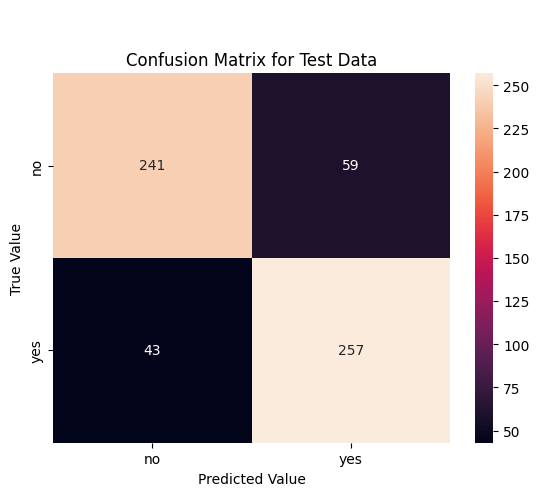

In [ ]:
base_model= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)

model = Model(inputs=base_model.input,outputs=predictions)

X_train_features = model.predict(X_train_prep)
X_val_features=model.predict(X_val_prep)
X_test_features=model.predict(X_test_prep)
models_compare(X_train_features, y_train, X_val_features, y_val, X_test_features, y_test)

### VGG-16

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                       

<ipython-input-56-fe43f07b46b3>:32: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/2
50/50 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8642 - auc: 0.9383

50/50 [==============================] - 44s 761ms/step - loss: 0.3257 - accuracy: 0.8642 - auc: 0.9383 - val_loss: 0.7349 - val_accuracy: 0.8825 - val_auc: 0.9278
Epoch 2/2
50/50 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9162 - auc: 0.9757

57/57 [==============================] - 7s 126ms/step

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 0.97


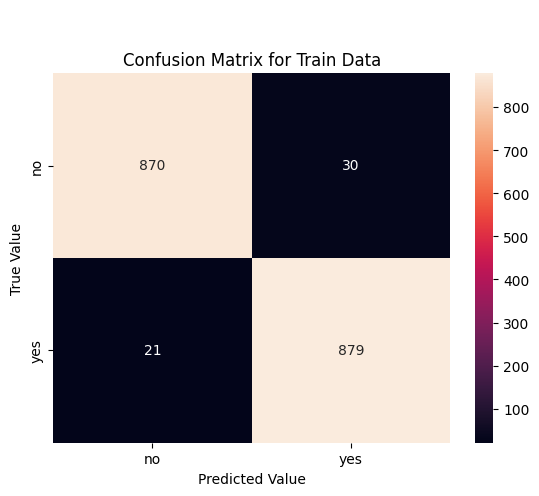

19/19 [==============================] - 6s 319ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.95


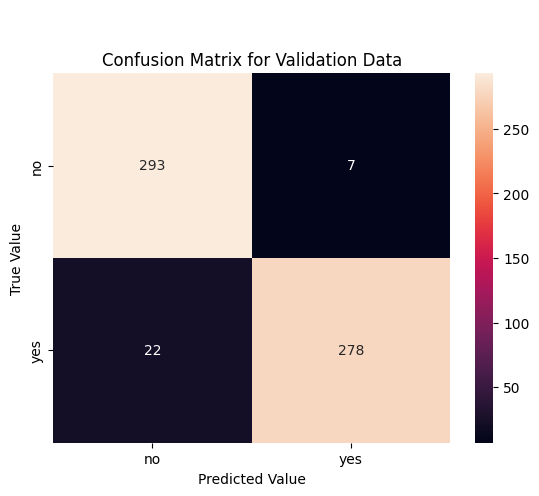

19/19 [==============================] - 2s 127ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.85
Precision score is : 0.8664
Recall score is : 0.855
F1 Score is : 0.8539
Cohen Kappa Score: 0.71

		Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84       300
           1       0.80      0.94      0.87       300

    accuracy                           0.85       600
   macro avg       0.87      0.85      0.85       600
weighted avg       0.87      0.85      0.85       600



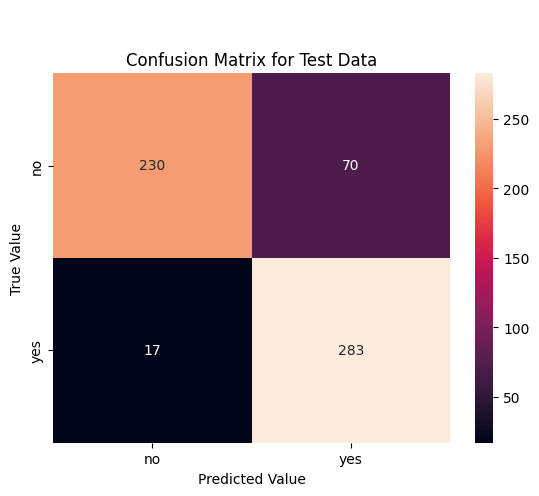

In [ ]:
#without adding ML classifiers
base_Neural_Net= VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()


EPOCHS = 2  #30
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

confusion_matrix_plot(model, X_train_prep, y_train, "Train Data")
confusion_matrix_plot(model, X_val_prep, y_val, "Validation Data")
confusion_matrix_plot(model, X_test_prep, y_test, "Test Data")

Using ML Classifiers

19/19 [==============================] - 2s 128ms/step
--------------------------------K Nearest Neighbour Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 0.89


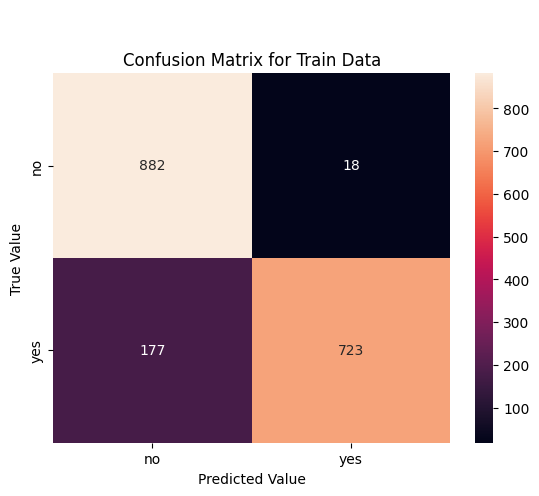


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.73


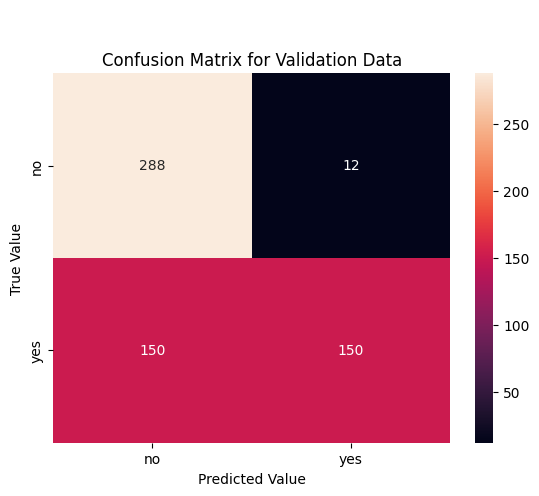


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.70
Precision score is : 0.6999
Recall score is : 0.6967
F1 Score is : 0.6954
Cohen Kappa Score: 0.3933

		Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71       300
           1       0.73      0.63      0.68       300

    accuracy                           0.70       600
   macro avg       0.70      0.70      0.70       600
weighted avg       0.70      0.70      0.70       600



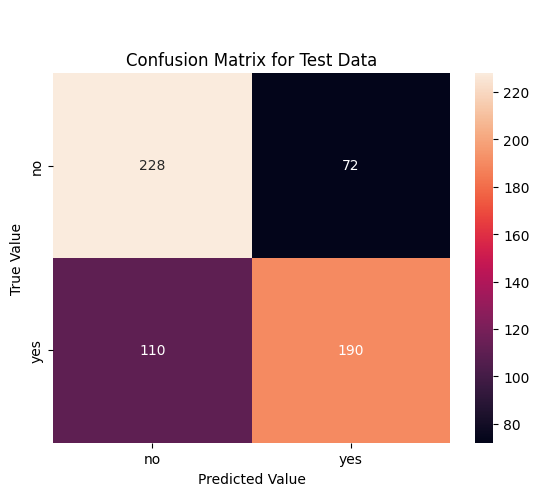

--------------------------------Random Forest Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 1.00


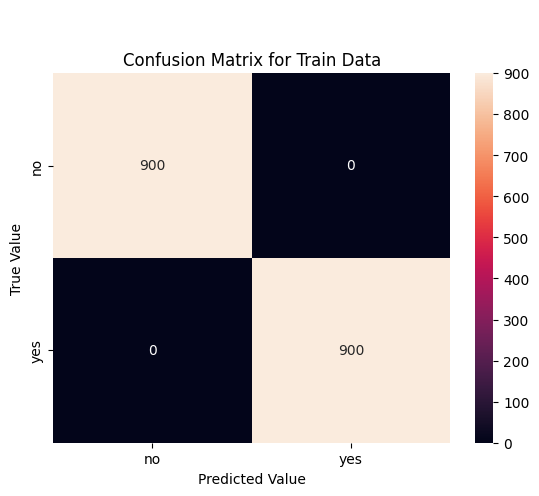


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.84


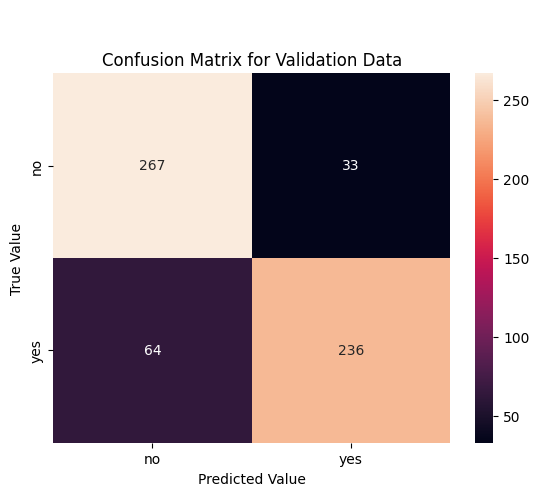


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.67
Precision score is : 0.6731
Recall score is : 0.665
F1 Score is : 0.661
Cohen Kappa Score: 0.33

		Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.56      0.62       300
           1       0.64      0.77      0.70       300

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.66       600
weighted avg       0.67      0.67      0.66       600



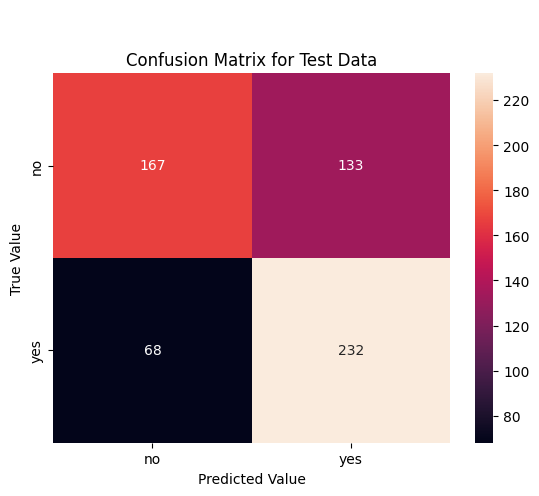

--------------------------------XGB Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 1.00


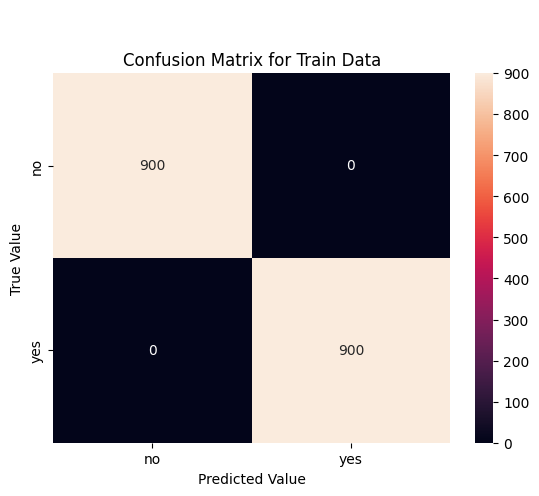


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.81


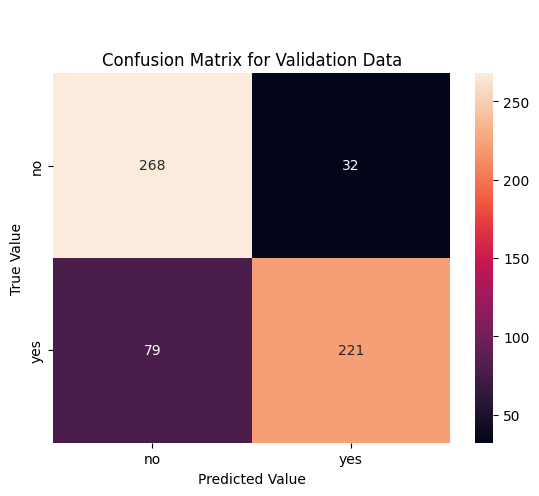


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.68
Precision score is : 0.6895
Recall score is : 0.6817
F1 Score is : 0.6783
Cohen Kappa Score: 0.3633

		Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.58      0.65       300
           1       0.65      0.78      0.71       300

    accuracy                           0.68       600
   macro avg       0.69      0.68      0.68       600
weighted avg       0.69      0.68      0.68       600



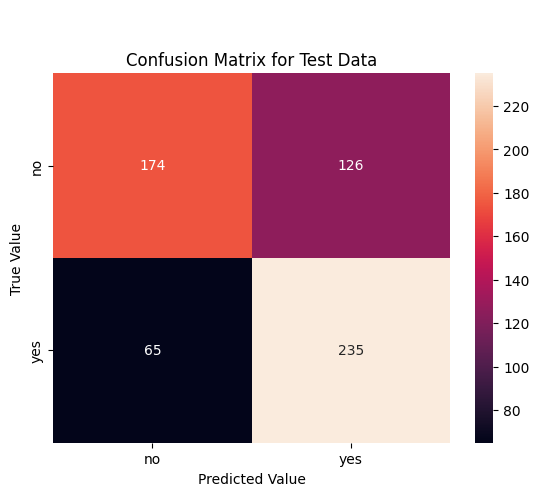

In [ ]:
base_model= VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(1 , activation='sigmoid')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

X_train_features = model_feat.predict(X_train_prep)
X_val_features=model_feat.predict(X_val_prep)
X_test_features=model_feat.predict(X_test_prep)

models_compare(X_train_features, y_train, X_val_features, y_val, X_test_features, y_test)  #0.9, 0.75, 0.72  ; 1,0.81,0.66

## **VGG19**

VGG19 without ML Classifiers

In [ ]:
base_Neural_Net= VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_8 (Batc  (None, 25088)            100352    
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_9 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                       

<ipython-input-59-51e5b5363327>:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/2
50/50 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8509 - auc: 0.9220

50/50 [==============================] - 37s 691ms/step - loss: 0.3771 - accuracy: 0.8509 - auc: 0.9220 - val_loss: 0.4538 - val_accuracy: 0.8900 - val_auc: 0.9613
Epoch 2/2
50/50 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9212 - auc: 0.9765

57/57 [==============================] - 9s 158ms/step

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 0.96


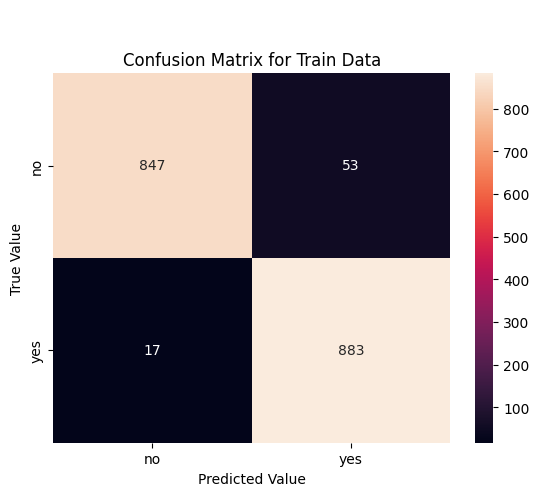

19/19 [==============================] - 3s 158ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.95


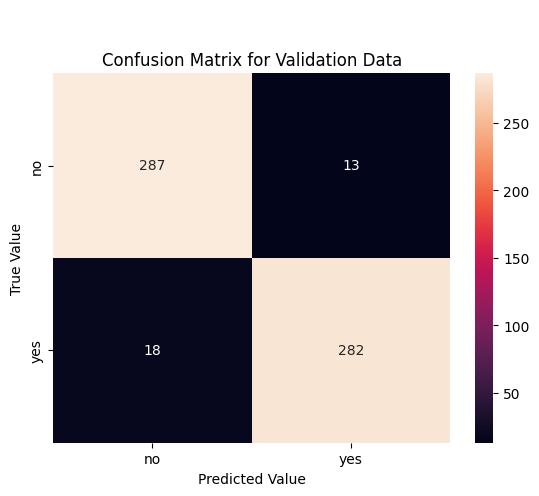

19/19 [==============================] - 3s 157ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.82
Precision score is : 0.8497
Recall score is : 0.8217
F1 Score is : 0.818
Cohen Kappa Score: 0.6433

		Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79       300
           1       0.75      0.96      0.84       300

    accuracy                           0.82       600
   macro avg       0.85      0.82      0.82       600
weighted avg       0.85      0.82      0.82       600



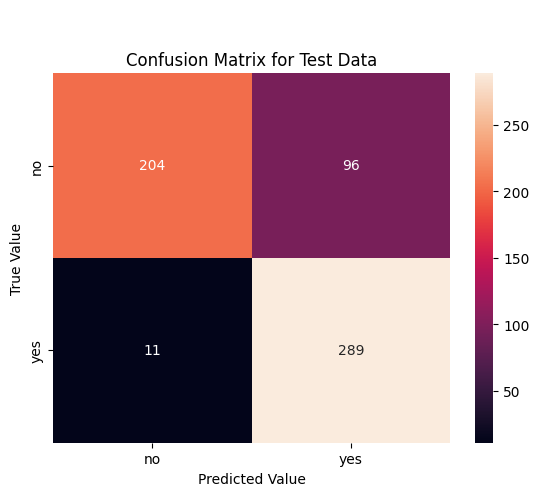

In [ ]:
EPOCHS = 2  #30
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

confusion_matrix_plot(model, X_train_prep, y_train, "Train Data")
confusion_matrix_plot(model, X_val_prep, y_val, "Validation Data")
confusion_matrix_plot(model, X_test_prep, y_test, "Test Data")

VGG19 with ML classifiers

19/19 [==============================] - 3s 153ms/step
--------------------------------K Nearest Neighbour Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 0.88


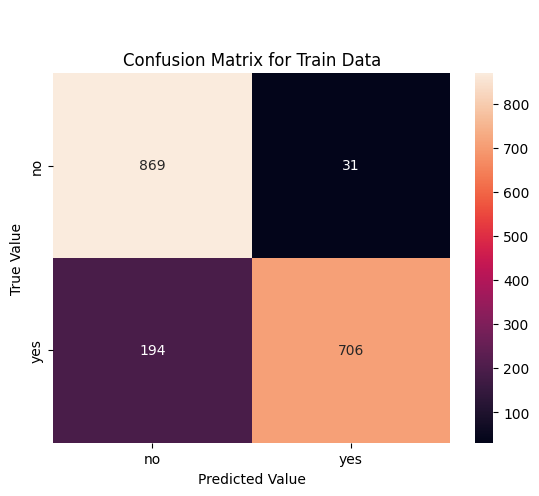


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.70


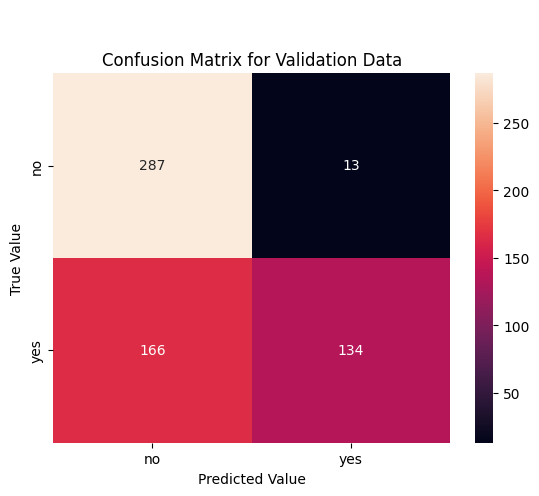


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.70
Precision score is : 0.7151
Recall score is : 0.705
F1 Score is : 0.7015
Cohen Kappa Score: 0.41

		Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.81      0.73       300
           1       0.76      0.60      0.67       300

    accuracy                           0.70       600
   macro avg       0.72      0.71      0.70       600
weighted avg       0.72      0.70      0.70       600



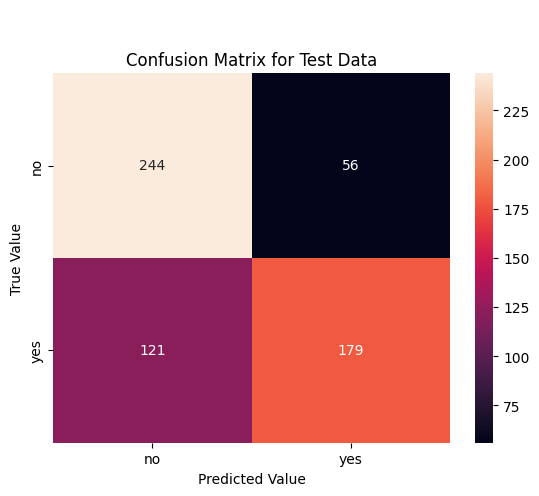

--------------------------------Random Forest Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 1.00


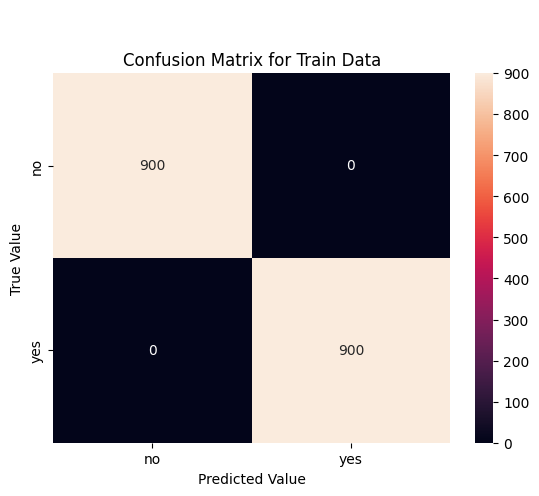


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.78


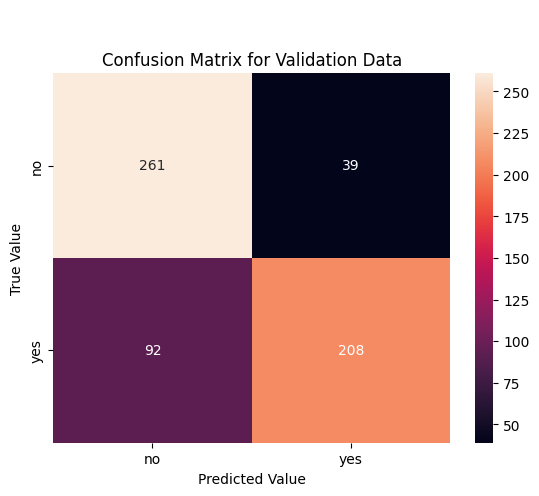


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.64
Precision score is : 0.6486
Recall score is : 0.64
F1 Score is : 0.6347
Cohen Kappa Score: 0.28

		Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.52      0.59       300
           1       0.61      0.76      0.68       300

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.63       600
weighted avg       0.65      0.64      0.63       600



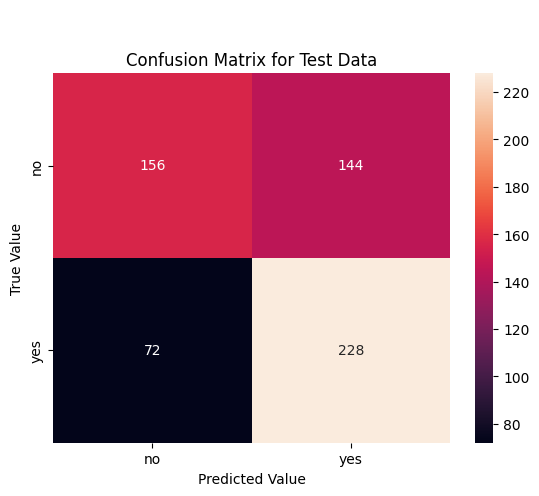

--------------------------------XGB Classifier---------------------------------- 

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 1.00


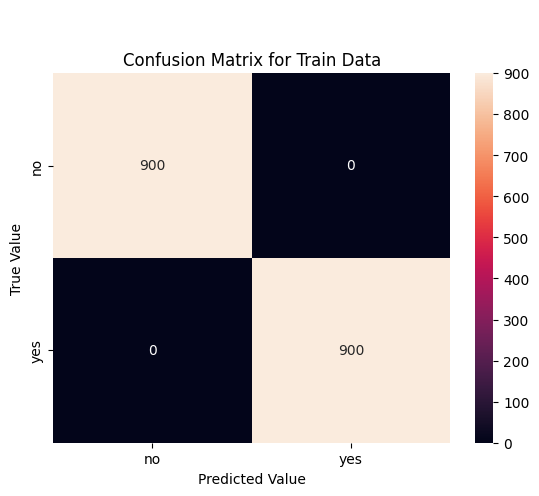


Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.80


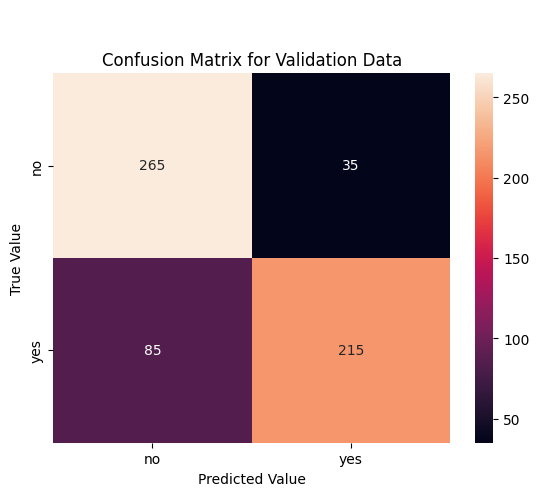


Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.68
Precision score is : 0.6821
Recall score is : 0.6783
F1 Score is : 0.6767
Cohen Kappa Score: 0.3567

		Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.61      0.65       300
           1       0.66      0.75      0.70       300

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.68      0.68      0.68       600



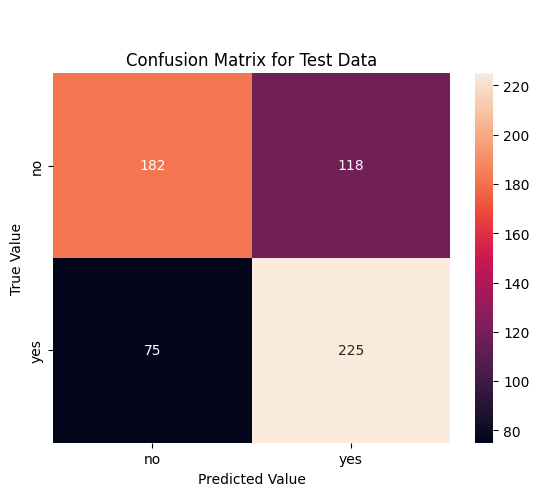

In [ ]:
base_model= VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

X_train_features = model_feat.predict(X_train_prep)
X_val_features=model_feat.predict(X_val_prep)
X_test_features=model_feat.predict(X_test_prep)

models_compare(X_train_features, y_train, X_val_features, y_val, X_test_features, y_test)

## **DenseNet-169**

DenseNet without ML classifiers

In [ ]:
base_Neural_Net= DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False


model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_6 (Flatten)         (None, 81536)             0         
                                                                 
 batch_normalization_12 (Bat  (None, 81536)            326144    
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               20873472  
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                       

<ipython-input-62-51e5b5363327>:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/2
50/50 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7227 - auc: 0.7827

50/50 [==============================] - 54s 778ms/step - loss: 0.6376 - accuracy: 0.7227 - auc: 0.7827 - val_loss: 1.8546 - val_accuracy: 0.5850 - val_auc: 0.7711
Epoch 2/2
50/50 [==============================] - ETA: 0s - loss: 0.5000 - accuracy: 0.7713 - auc: 0.8424

57/57 [==============================] - 9s 117ms/step

Shape of y: (1800,)
Shape of predictions: 1800

------------------------Train Dataset Metrics------------------------


Train Data Accuracy Score = 0.68


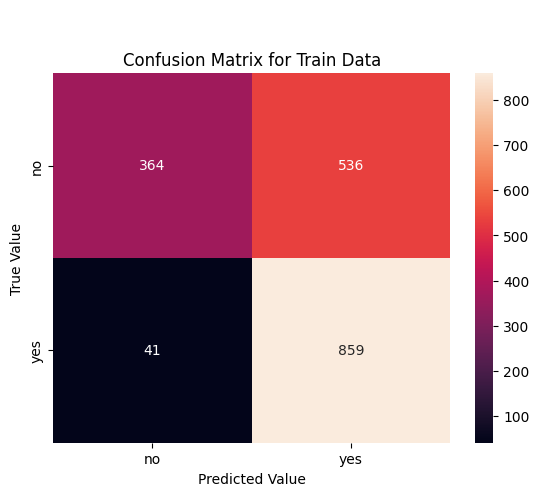

19/19 [==============================] - 5s 252ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Validation Dataset Metrics------------------------


Validation Data Accuracy Score = 0.68


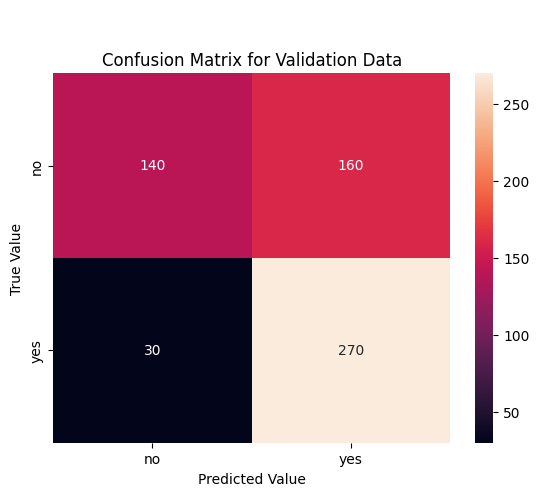

19/19 [==============================] - 2s 114ms/step

Shape of y: (600,)
Shape of predictions: 600

------------------------Test Dataset Metrics------------------------


Test Data Accuracy Score = 0.65
Precision score is : 0.7092
Recall score is : 0.6467
F1 Score is : 0.6181
Cohen Kappa Score: 0.2933

		Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.37      0.51       300
           1       0.59      0.92      0.72       300

    accuracy                           0.65       600
   macro avg       0.71      0.65      0.62       600
weighted avg       0.71      0.65      0.62       600



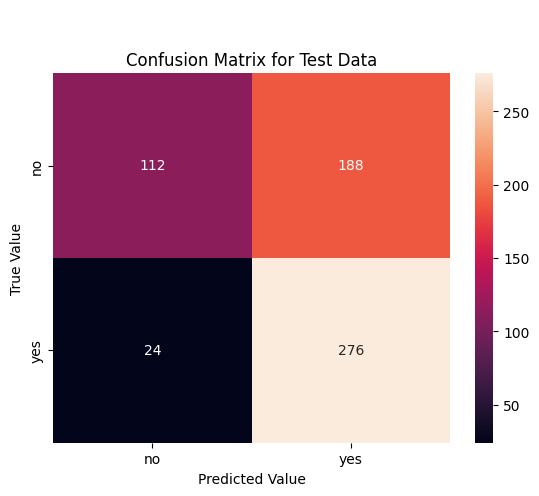

In [ ]:
EPOCHS = 2  #30
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

confusion_matrix_plot(model, X_train_prep, y_train, "Train Data")
confusion_matrix_plot(model, X_val_prep, y_val, "Validation Data")
confusion_matrix_plot(model, X_test_prep, y_test, "Test Data")

DenseNet with ML classifiers

In [ ]:
base_model= DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(64,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
predictions = Activation('relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(3, activation='softmax')(x)

model_feat = Model(inputs=base_model.input,outputs=predictions)

X_train_features = model_feat.predict(X_train_prep)
X_val_features=model_feat.predict(X_val_prep)
X_test_features=model_feat.predict(X_test_prep)

models_compare(X_train_features, y_train, X_val_features, y_val, X_test_features, y_test)

In [ ]:
# clean up the space
#!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP

In [ ]:
from tabulate import tabulate
#https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-table-style/
dict = {'Models'     : ['ResNet50','VGG16' ],
        'Train RMSE' : [LR_rmse1,LR_rmse2,RR_rmse1,RR_rmse2,RF_rmse1,RF_rmse2,XG_rmse1,LG_rmse2,LG_rmse1],
        'Test RMSE'  : ['2008963.26121','1860540.32767','1896964.73396','1860242.72457','1793799.39578','1836348.18595','1799180.97203','1796924.10396','1770449.14498']
        }
df = pd.DataFrame(dict)
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

In [4]:
cnn_model = ...
